# Ultimate Technologies Inc. Take-Home Challenge

Contents:

## Part 1 - Exploratory data analysis

The logins.json file contains (simulated) timestamps of user logins in a particular geographic location. 

<u>Tasks:</u>
- Aggregate these login counts based on 15 minute time intervals.
- Visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. 
- Report/illustrate important features of the demand, such as daily cycles. 
- If there are data quality issues, please report them.

## Import packages and load files

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from datetime import datetime

sns.set_theme()

In [2]:
#load file
logins = pd.read_json('logins.json')

## Data cleaning

In [3]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
#check for null values
logins.isnull().sum()

login_time    0
dtype: int64

In [6]:
#check for duplicates
sum(logins.duplicated())

877

Possible that these are valid, multiple people logging on at the same time.

In [7]:
print(min(logins['login_time']))
print(max(logins['login_time']))

1970-01-01 20:12:16
1970-04-13 18:57:38


We are looking at roughly a three and half month time period, from January 1, 1970 to April 13, 1970.

## Aggregate by 15 minute intervals

In [8]:
logins_15 = pd.DataFrame(logins.resample('15 min', on = 'login_time', kind='timestamp').login_time.count())

logins_15.rename(columns = {'login_time':'Count'}, inplace=True)

logins_15

,Count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1
...,...
1970-04-13 17:45:00,5
1970-04-13 18:00:00,5
1970-04-13 18:15:00,2


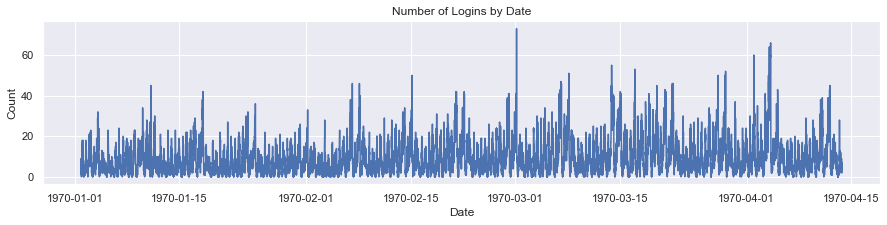

In [9]:
# graph the time series
plt.figure(figsize=(15,3))
sns.lineplot(x = logins_15.index, y=logins_15['Count'])
plt.xlabel('Date')
plt.ylabel('Count')
plt.title('Number of Logins by Date')
plt.show()

We can definitely observe a certain pattern emerging, perhaps a weekly pattern that may be worth exploring.  We'll plot the rolling average of logins over 24 hours to see if we can see this pattern more clearly.

In [10]:
#create rolling average
logins_roll = logins_15.rolling('24h').mean()

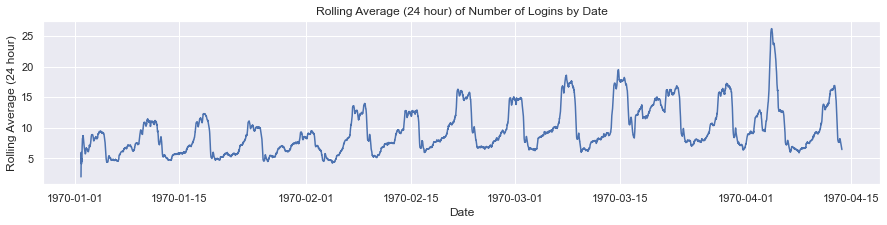

In [11]:
# graph the rolling average time series
plt.figure(figsize=(15,3))
sns.lineplot(x = logins_roll.index, y=logins_roll['Count'])
plt.xlabel('Date')
plt.ylabel('Rolling Average (24 hour)')
plt.title('Rolling Average (24 hour) of Number of Logins by Date')
plt.show()

Certainly looks like there is some seasonality that is worth exploring. We'll prepare our dataframe for further aggregations by time of day, and day of week.

In [12]:
logins_15['Day'] = logins_15.index.day_name()
logins_15['Hour'] = logins_15.index.hour

In [13]:
logins_15

,Count,Day,Hour
login_time,,,
1970-01-01 20:00:00,2,Thursday,20
1970-01-01 20:15:00,6,Thursday,20
1970-01-01 20:30:00,9,Thursday,20
1970-01-01 20:45:00,7,Thursday,20
1970-01-01 21:00:00,1,Thursday,21
...,...,...,...
1970-04-13 17:45:00,5,Monday,17
1970-04-13 18:00:00,5,Monday,18
1970-04-13 18:15:00,2,Monday,18


## Logins by day of week

In [14]:
# create a new dataframe by grouping by hour and adding counts
logins_day = pd.DataFrame(logins_15.groupby(by='Day', as_index=False)['Count'].sum())
logins_day

,Day,Count
0,Friday,15208
1,Monday,8823
2,Saturday,19377
3,Sunday,18167
4,Thursday,11960
5,Tuesday,9268
6,Wednesday,10339


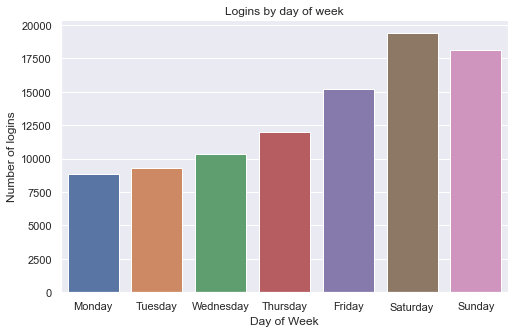

In [15]:
# plot barplot for number of logins by day of week
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.figure(figsize = (8, 5))
sns.barplot(x='Day', y="Count", data=logins_day, order=order_days)
plt.xlabel('Day of Week')
plt.ylabel('Number of logins')
plt.title('Logins by day of week')
plt.show()

Logins are consistently increasing from Monday to Saturday.  There is a slight dip in number of logins from Saturday to Sunday, but overall, there are more logins on the weekends than weekdays.

## Logins by hour of day

In [16]:
# create a new dataframe by grouping by hour and adding counts
logins_hour = pd.DataFrame(logins_15.groupby(by='Hour', as_index=False)['Count'].sum())
logins_hour.head()

,Hour,Count
0,0,5993
1,1,6317
2,2,5800
3,3,4831
4,4,5034


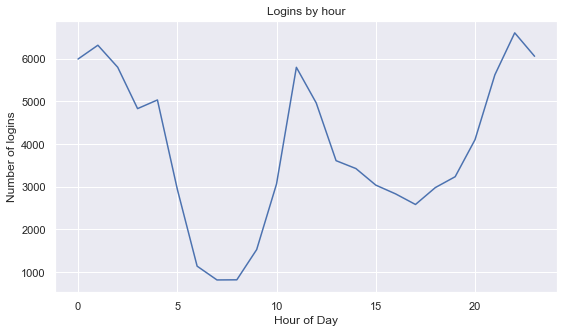

In [17]:
plt.figure(figsize=(9, 5))
sns.lineplot(x='Hour', y = 'Count', data = logins_hour)
plt.xlabel('Hour of Day')
plt.ylabel('Number of logins')
plt.title('Logins by hour')
plt.show()

Within a single 24 hour period, it seems that most logins take place in between 21:00 and 2:00.  There is also a spike in the middle of the morning at 11:00 am.  We'll examine this further by breaking down the logins by hour for each day of the week.

## Logins by day of week and hour

In [18]:
# create a new dataframe by grouping by day and then hourhour and adding counts
logins_dh = pd.DataFrame(logins_15.groupby(by=['Day', 'Hour'], as_index=False)['Count'].sum())
logins_dh.head(20)

,Day,Hour,Count
0,Friday,0,975
1,Friday,1,957
2,Friday,2,771
3,Friday,3,502
4,Friday,4,353
5,Friday,5,245
6,Friday,6,121
7,Friday,7,105
8,Friday,8,109
9,Friday,9,240


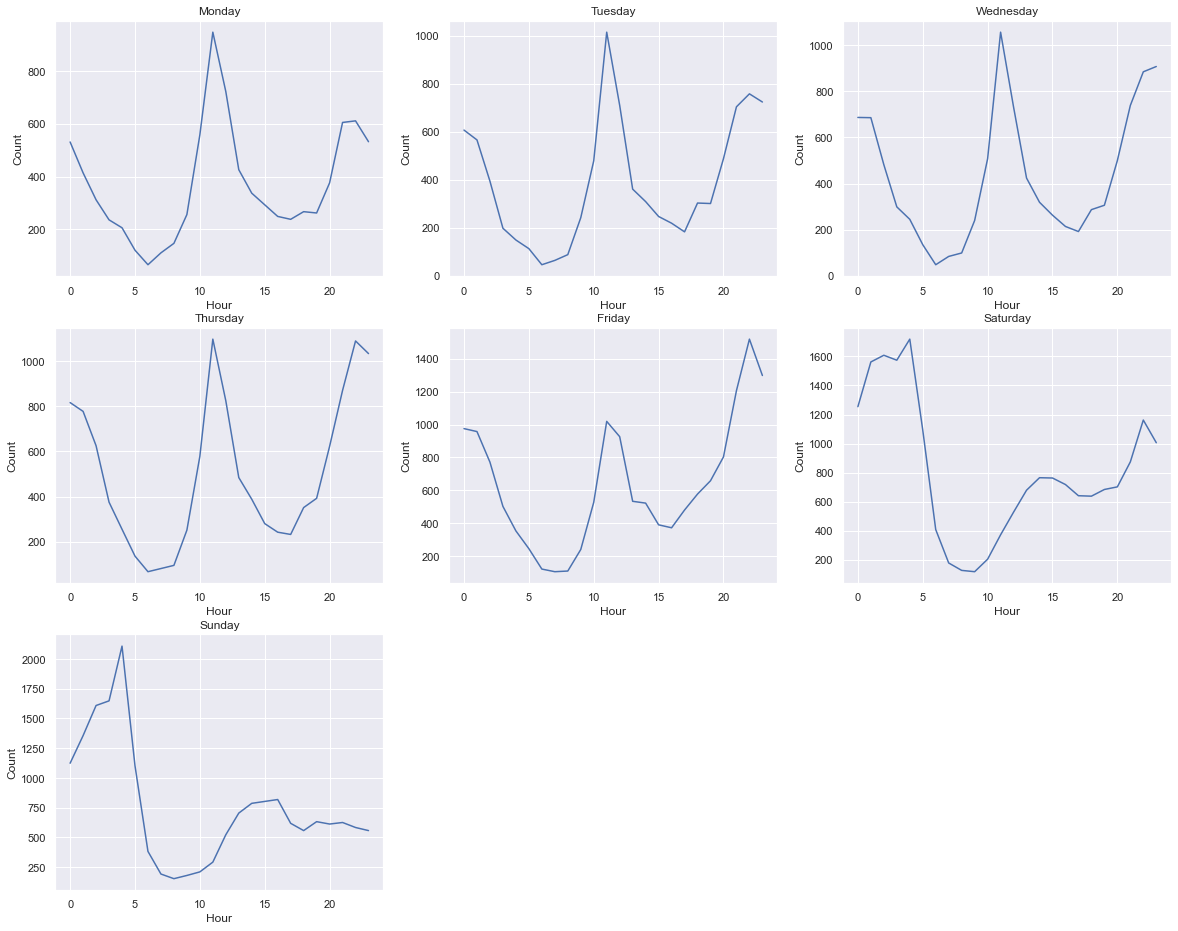

In [19]:
a=3
b=3
c=1

fig = plt.figure(figsize=(20,16))

for day in order_days:
    plt.subplot(a,b,c)
    sns.lineplot(x='Hour', y = 'Count', data = logins_dh[logins_dh['Day']==day])
    plt.title(day)
    c=c+1

plt.show()

From Monday to Thursday, we see similar patterns where there is a peak of logins mid morning, around 11:00. As the week progresses, we see that the evening peak begins to get higher and higher until Friday, where the evening peak of logins surpasses the mid morning peak of logins.  

On Saturday and Sunday, we see different behavior where the peak number of logins is from 1:00 to 4:00.

## Part 2 - Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. <b>What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?</b>

Based on the provided background information, it seems that the main purpose of this experiment is to encourage driver partners to be available in both cities.  Furthermore, since the cities are active during opposite times on weekdays, it's unlikely that drivers will be willing to be available in both cities even with the toll reimbursement.

As a result, I would focus on the measuring the increase in number of times drivers cross the bridge on weekends only (and not weekdays).  

2. <b>Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:</b>
    1. how you will implement the experiment
    2. what statistical test(s) you will conduct to verify the significance of the observation
    3. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

To implement this experiment, I would compare the number of times drivers cross the bridge <i>before</i> the implementation of this reimbursement policy with the number of times drivers cross the bridge <i>after</i> the implementation of this policy.  

The experiment will run over eight weekends (defined as Saturday and Sunday).  We'll identify all drivers that are active on weekends and then randomly select 100 of them (or more depending on how many drivers there are in total) and track the number of times they cross the bridge for four weeks without the reimbursement policy (control), and then another four weeks after the reimbursement policy is implemented (treatment).  

We can then take the difference of each drivers number of bridge crossings from before and after the implementation of this policy, and perform a <b>paired <i>t</i>-test</b>. In other words, for each driver they will do both the control and the treatment.

We would use the following as our null hypothesis and alternative hypothesis, and set our significance level $\alpha = 0.05$.

<br>

<center>$H_0: \mu_{\text{after } - \text{ before}} = 0$</center>
<br>
<center>$H_A: \mu_{\text{after } - \text{ before}} > 0$</center>

Once we have our observed mean of differences, we would calculate the t-statistic, find the p-value from the t-distribution (combined with the degrees of freedom), and then compare the p-value with our significance level.


If our p-value is < 0.05, then this means that there is a less than 5% chance of seeing our sample mean of differences under the assumption that the underlying population mean of differences is 0 (null hypothesis).  If this is the case, we would feel confident in rejecting the null hypothesis.  This means that the implementation of the policy has successfully encouraged drivers to be available in both cities on weekends and we would recommend that the reimbursement policy continue.

If our p-value is $\geq$ 0.05, then this means that the chance of seeing our sample mean of differences under the null hypothesis is greater or equal to 5%.  If this is the case, we would <b>not</b> reject the null hypothesis and we would recommend further analysis before making a decision on this reimbursement policy.

Of course, this is only a study of how the reimbursement policy affects inter-city trips on weekends only.  It may be worth also running the same experiment for weekdays as well.  Also, this experiment was performed on the assumption that the objective was to encourage drivers to be available on both sides of the bridge.  There was no mention of how this reimbursement policy would impact revenue, but this may also be a worthwhile test as well.

## Part 3 - Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long term rider retention (again, a few sentences will suffice).


### Data description:

- <b>city:</b> city this user signed up in
- <b>phone:</b> primary device for this user
- <b>signup_date:</b> date of account registration; in the form ‘YYYYMMDD’
- <b>last_trip_date:</b> the last time this user completed a trip; in the form ‘YYYYMMDD’
- <b>avg_dist:</b> the average distance in miles per trip taken in the first 30 days after signup
- <b>avg_rating_by_driver:</b> the rider’s average rating over all of their trips
- <b>avg_rating_of_driver:</b> the rider’s average rating of their drivers over all of their trips
- <b>surge_pct:</b> the percent of trips taken with surge multiplier > 1
- <b>avg_surge:</b> The average surge multiplier over all of this user’s trips
- <b>trips_in_first_30_days:</b> the number of trips this user took in the first 30 days after signing up
- <b>ultimate_black_user:</b> TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- <b>weekday_pct:</b> the percent of the user’s trips occurring during a weekday

### Import packages and load files

In [20]:
#load file
df = pd.read_json('ultimate_data_challenge.json')

### Data cleaning

In [21]:
#observe first 5 rows
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [22]:
# observe last 5 rows
df.tail()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
49995,King's Landing,0,2014-01-25,5.0,1.0,2014-06-05,iPhone,0.0,False,100.0,5.63,4.2
49996,Astapor,1,2014-01-24,NaN,1.0,2014-01-25,iPhone,0.0,False,0.0,0.00,4.0
49997,Winterfell,0,2014-01-31,5.0,1.0,2014-05-22,Android,0.0,True,100.0,3.86,5.0
49998,Astapor,2,2014-01-14,3.0,1.0,2014-01-15,iPhone,0.0,False,100.0,4.58,3.5
49999,Astapor,0,2014-01-18,NaN,1.0,2014-04-20,Android,0.0,False,0.0,3.49,5.0


In [23]:
#check number of rows and columns
df.shape

(50000, 12)

Our dataframe has 50,000 rows and 12 columns in its original state.

In [24]:
#check for duplicate rows
sum(df.duplicated())

8

In [25]:
#identify rows that are duplicates
df[df.duplicated()]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
2608,Astapor,1,2014-01-18,5.0,1.0,2014-01-19,iPhone,0.0,True,0.0,6.25,5.0
18057,Astapor,1,2014-01-11,5.0,1.0,2014-01-11,iPhone,0.0,True,0.0,2.33,5.0
29601,Winterfell,1,2014-01-01,NaN,1.0,2014-01-02,Android,0.0,False,100.0,8.08,5.0
34641,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,iPhone,0.0,True,0.0,1.44,5.0
36627,Winterfell,1,2014-01-18,5.0,1.0,2014-01-19,Android,0.0,False,0.0,3.54,5.0
39601,Winterfell,1,2014-01-10,5.0,1.0,2014-01-11,Android,0.0,False,100.0,0.00,5.0
42025,Winterfell,1,2014-01-18,NaN,1.0,2014-01-19,Android,0.0,False,0.0,0.01,5.0
45416,Astapor,1,2014-01-20,5.0,1.0,2014-01-20,iPhone,0.0,False,100.0,3.06,5.0


Since it's unlikely that two different customers have the exact same value for every single one of the 12 features, it's most likely that these are duplicate entries.  I would certainly consult with the client to ensure that these are duplicates and if so, then proceed to delete them.  Here we will assume that they are indeed duplicates.

In [26]:
#drop duplicates
df.drop_duplicates(ignore_index = True, inplace=True)

In [27]:
#check for null values
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8119
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

Looks like we have missing values in the following columns:
- avg_rating_of_driver
- phone
- avg_rating_by_driver

Since we cannot infer which phone the user has without another predictive model, we will drop the rows where 'phone' is missing.

In [28]:
# drop rows where phone is NaN
df = df.drop(df[df.phone.isna()==True].index,axis=0)

In [29]:
# check for null values again
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8023
avg_surge                    0
last_trip_date               0
phone                        0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       198
dtype: int64

We'll try to impute the missing values of avg_rating_of_driver and avg_rating_by_driver, based on which value best represents the central tendency of these two features.

We'll start by examining the 'avg_rating_of_driver' feature.

In [30]:
df['avg_rating_of_driver'].describe()

count    41573.000000
mean         4.601419
std          0.617399
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

In [31]:
mean_of = df['avg_rating_of_driver'].mean()
median_of = df['avg_rating_of_driver'].median()
mode_of = df['avg_rating_of_driver'].mode()[0]

print('Measures of Central Tendency of avg_rating_of_driver')
print('Mean: {}'.format(mean_of))
print('Median: {}'.format(median_of))
print('Mode: {}'.format(mode_of))

Measures of Central Tendency of avg_rating_of_driver
Mean: 4.601419190339883
Median: 4.9
Mode: 5.0


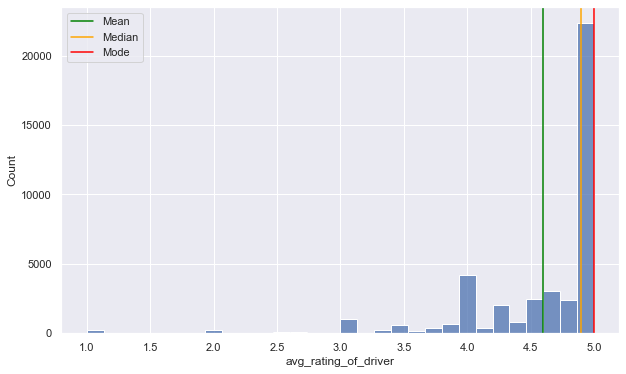

In [32]:
# generate histogram of avg_rating_of_driver with locations of measures of central tendency
plt.figure(figsize=(10,6))
sns.histplot(df['avg_rating_of_driver'], bins = 30)
plt.axvline(x = mean_of, color = 'green')
plt.axvline(x = median_of, color = 'orange')
plt.axvline(x = mode_of, color = 'red')
plt.legend({'Mean':mean_of, 'Median':median_of, 'Mode':mode_of})
plt.show()

Given that this is a left-tailed distribution with strong skew, it does not make sense to impute the missing values of 'avg_rating_of_driver' with the mean.  The mode value of 5 certainly has the most values, but we'll impute the missing values with the median to take into account that there are values on the lower end of this histogram.

In [33]:
# fill missing values of avg_rating_of_driver with median
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(median_of)

Now we'll perform the same examination of 'avg_rating_by_driver'

In [34]:
df['avg_rating_by_driver'].describe()

count    49398.000000
mean         4.777825
std          0.447141
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

In [35]:
mean_by = df['avg_rating_by_driver'].mean()
median_by = df['avg_rating_by_driver'].median()
mode_by = df['avg_rating_by_driver'].mode()[0]

print('Measures of Central Tendency of avg_rating_by_driver')
print('Mean: {}'.format(mean_by))
print('Median: {}'.format(median_by))
print('Mode: {}'.format(mode_by))

Measures of Central Tendency of avg_rating_by_driver
Mean: 4.777825013158427
Median: 5.0
Mode: 5.0


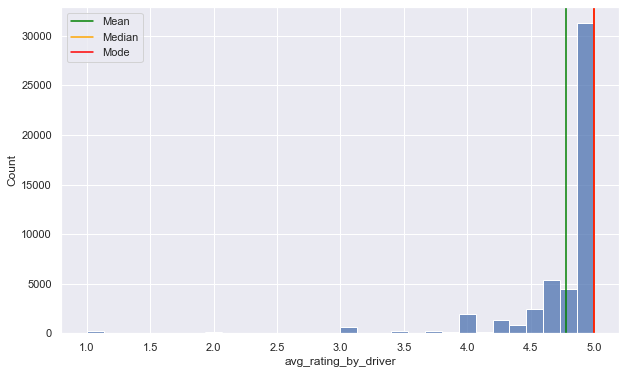

In [36]:
# generate histogram of avg_rating_by_driver with locations of measures of central tendency
plt.figure(figsize=(10,6))
sns.histplot(df['avg_rating_by_driver'], bins = 30)
plt.axvline(x = mean_by, color = 'green')
plt.axvline(x = median_by, color = 'orange')
plt.axvline(x = mode_by, color = 'red')
plt.legend({'Mean':mean_by, 'Median':median_by, 'Mode':mode_by})
plt.show()

Once again, we are looking at a left-tailed distribution, so it will not make sense to impute missing values with the mean.  In the case, since the median and mode are identical, we will impute missing values of avg_rating_by_driver with this value, which is 5.

In [37]:
# fill missing values of avg_rating_of_driver with median
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(median_by)

In [38]:
#check for null values again
df.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [39]:
# check shape again
df.shape

(49596, 12)

Great! We've managed to address missing values with minimal loss of data from the original dataset.  

Next we'll look at the datatypes of each feature.

In [40]:
# check datatypes
df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

Most of our features seem to be in order.  The only datatypes that need to be changed are 'signup_date' and 'last_trip_date'.  Both of these will be changed to datetime format.

In [41]:
#convert to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

In [42]:
df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

### Feature engineering

We'll need to engineer our target variable, which will be a binary variable indicating user retention.  User retention will be determined by whether they were active (i.e. took a trip) in the last 30 days.

We'll start by taking a look at the overview of values in each of our two date variables.

In [43]:
df['signup_date'].describe(datetime_is_numeric=True)

count                            49596
mean     2014-01-16 13:02:56.820711424
min                2014-01-01 00:00:00
25%                2014-01-09 00:00:00
50%                2014-01-17 00:00:00
75%                2014-01-24 00:00:00
max                2014-01-31 00:00:00
Name: signup_date, dtype: object

In [44]:
df['last_trip_date'].describe(datetime_is_numeric=True)

count                            49596
mean     2014-04-19 11:35:38.398257664
min                2014-01-01 00:00:00
25%                2014-02-15 00:00:00
50%                2014-05-08 00:00:00
75%                2014-06-18 00:00:00
max                2014-07-01 00:00:00
Name: last_trip_date, dtype: object

Since the max value of 'last_trip_date' is 2014-07-01, we'll assume that this is when the data was pulled.  We'll set this is the 'current_date' and use this the determine whether a user was active in the last 30 days.

In [45]:
#set current date
current_date = df['last_trip_date'].max()

In [46]:
# create target variable 'is_active'
df['is_active'] = df['last_trip_date'].apply(lambda date: 0 if (current_date-date).days > 30 else 1)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,is_active
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


### Exploratory data analysis

<b>Question:</b> What fraction of the observed users were retained?

In [47]:
pct_retained = (len(df[df['is_active']==1]) / len(df))*100

print('Percentage of observed users retained:', str(round(pct_retained, 2)) + '%')

Percentage of observed users retained: 37.65%


Ultimate has only retained 37.65% of its users.

<b>Question:</b> Which city are active users and non-active users primarily from?

In [48]:
df.city.unique()

array(["King's Landing", 'Astapor', 'Winterfell'], dtype=object)

Our riders are from three cities: King's Landing, Astapor, and Winterfell.

In [49]:
cities_act = df[df['is_active']==1].groupby('city')['trips_in_first_30_days'].count()
cities_inact = df[df['is_active']==0].groupby('city')['trips_in_first_30_days'].count()

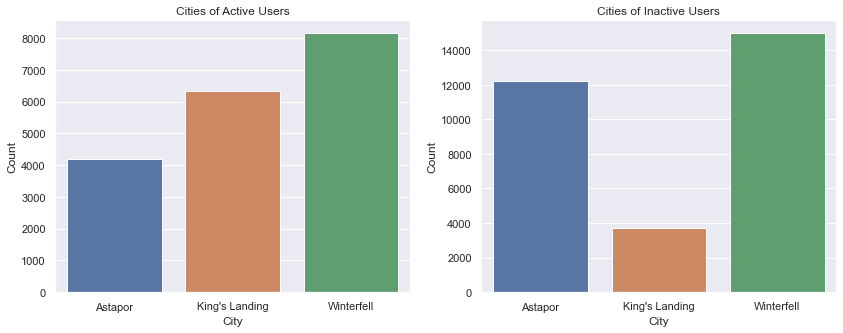

In [50]:
# plot bargraphs of count of cities by active and inactive users
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

sns.barplot(ax=ax1, x=cities_act.index, y=cities_act)
ax1.set_xlabel('City')
ax1.set_ylabel('Count')
ax1.set_title('Cities of Active Users')

sns.barplot(ax=ax2, x=cities_inact.index, y=cities_inact)
ax2.set_xlabel('City')
ax2.set_ylabel('Count')
ax2.set_title('Cities of Inactive Users')

plt.show()

The city with the most active users is Winterfell.  The city with the least active users is Astapor.

The cities with the most inactive users are Winterfell and Astapor.  The city with the least inactive users is King's Landing.

<b>Question:</b> Which phone do our active and inactive users primarily use?

In [51]:
phone_act = df[df['is_active']==1].groupby('phone')['trips_in_first_30_days'].count()
phone_inact = df[df['is_active']==0].groupby('phone')['trips_in_first_30_days'].count()

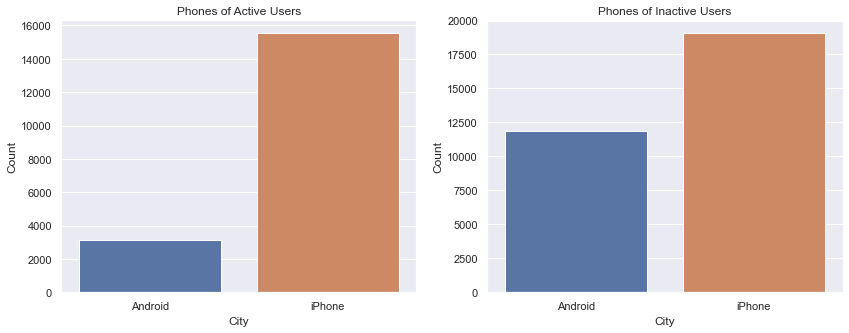

In [52]:
# plot bargraphs of count of cities by active and inactive users
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

sns.barplot(ax=ax1, x=phone_act.index, y=phone_act)
ax1.set_xlabel('City')
ax1.set_ylabel('Count')
ax1.set_title('Phones of Active Users')

sns.barplot(ax=ax2, x=phone_inact.index, y=phone_inact)
ax2.set_xlabel('City')
ax2.set_ylabel('Count')
ax2.set_title('Phones of Inactive Users')

plt.show()

The vast majority of our active users use iPhones.  Among inactive users, there are definitely more iPhone users, but the difference is not as large.

<b>Question:</b> How does the average distance (in first 30 days of signup) compare for active users vs inactive users?

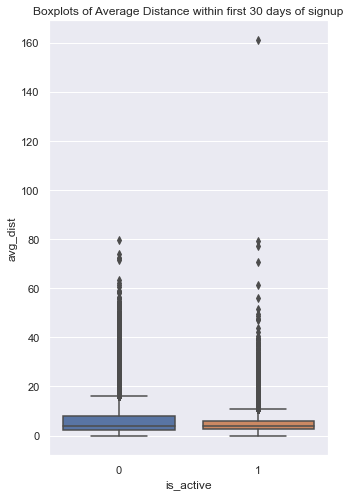

In [53]:
plt.figure(figsize=(5,8))
sns.boxplot(x='is_active', y='avg_dist', data = df)
plt.title('Boxplots of Average Distance within first 30 days of signup')
plt.show()

There is a clear outlier here in our data among those who are active.  While it may be a valid value for the average distance, it may affect our model's performance.  I would consult with the client and discuss removing this row.  Here, we will assume this conversation has happened.

In [54]:
#find the row with this highest value of avg_dist
df[df['avg_dist'] == max(df['avg_dist'])]

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,is_active
20699,Astapor,0,2014-01-25,4.9,1.0,2014-06-26,Android,0.0,False,100.0,160.96,5.0,1


In [55]:
# drop this row
df = df.drop(df[df['avg_dist'] == max(df['avg_dist'])].index,axis=0)

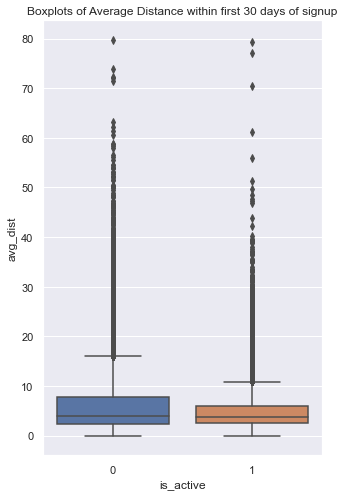

In [56]:
# regraph boxplots
plt.figure(figsize=(5, 8))
sns.boxplot(x='is_active', y='avg_dist', data = df)
plt.title('Boxplots of Average Distance within first 30 days of signup')
plt.show()

In [57]:
pd.pivot_table(df, index='is_active', aggfunc={'avg_dist':['mean','median','std']})

avg_dist                 
               mean median       std
is_active                           
0          6.191528   4.03  6.184459
1          5.105583   3.73  4.474816

The boxplots are similar, but it does seem like our inactive users, on average, have slightly higher avg_dist values.  This is unexpected, because we would have expected that active users would have traveled for longer distances, on average, in the first 30 days.

<b>Question:</b> How does the number of trips (in first 30 days of signup) compare for active users vs inactive users?

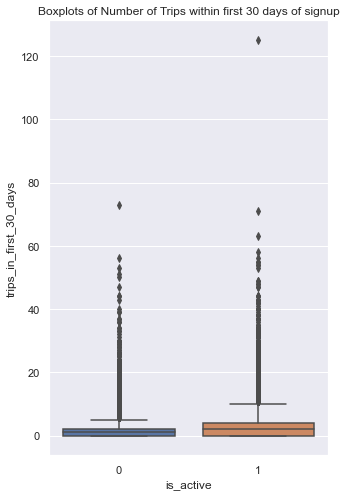

In [58]:
# regraph boxplots
plt.figure(figsize=(5, 8))
sns.boxplot(x='is_active', y='trips_in_first_30_days', data = df)
plt.title('Boxplots of Number of Trips within first 30 days of signup')
plt.show()

In [59]:
pd.pivot_table(df, index='is_active', aggfunc={'trips_in_first_30_days':['mean','median','std']})

trips_in_first_30_days                 
                            mean median       std
is_active                                        
0                       1.657203    1.0  2.656090
1                       3.304981    2.0  4.985132

On average, it seems like active users took more trips in their first 30 days of signup than inactive users.

<b>Question:</b> How does the rider's average rating compare for inactive vs active users?

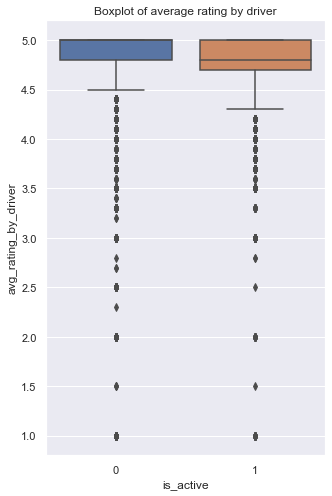

In [60]:
plt.figure(figsize=(5,8))
sns.boxplot(x='is_active', y='avg_rating_by_driver', data = df)
plt.title('Boxplot of average rating by driver')
plt.show()

In [61]:
pd.pivot_table(df, index='is_active', aggfunc={'avg_rating_by_driver':['mean','median','std']})

avg_rating_by_driver                 
                          mean median       std
is_active                                      
0                     4.788097    5.0  0.504135
1                     4.763155    4.8  0.328876

On average, inactive users have a higher average rating by driver, but not by much.

<b>Question:</b> How does the rider's average rating of drivers compare for inactive vs active users?

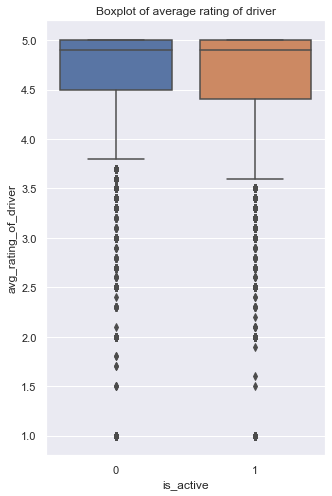

In [62]:
plt.figure(figsize=(5,8))
sns.boxplot(x='is_active', y='avg_rating_of_driver', data = df)
plt.title('Boxplot of average rating of driver')
plt.show()

In [63]:
pd.pivot_table(df, index='is_active', aggfunc={'avg_rating_of_driver':['mean','median','std']})

avg_rating_of_driver                 
                          mean median       std
is_active                                      
0                     4.667842    4.9  0.603366
1                     4.619689    4.9  0.525787

There is not much of a difference here, but on average, inactive users give <i>slightly</i> higher ratings of their driver.  This indicates that low driver satisfaction may not be a reason why users decide to become inactive.

<b>Question:</b> How do the percentage of trips taken with surge > 1 compare for inactive users vs active users?

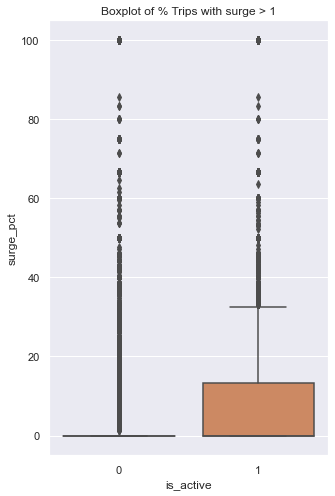

In [64]:
plt.figure(figsize=(5,8))
sns.boxplot(x='is_active', y='surge_pct', data = df)
plt.title('Boxplot of % Trips with surge > 1')
plt.show()

In [65]:
pd.pivot_table(df, index='is_active', aggfunc={'surge_pct':['mean','median','std']})

surge_pct                  
               mean median        std
is_active                            
0          8.702341    0.0  22.223566
1          9.166106    0.0  15.599926

Active users, on average, have higher percentages of trips that have surge > 1 than inactive users.

<b>Question:</b> How does the average surge multiplier over all the users trips compare for inactive users vs active users?

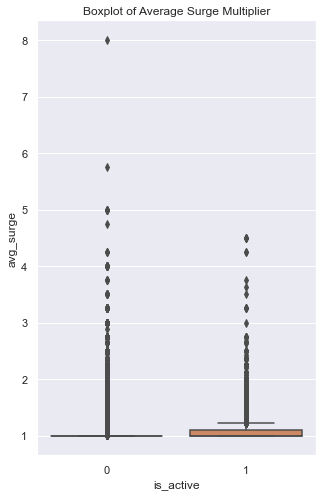

In [66]:
plt.figure(figsize=(5,8))
sns.boxplot(x='is_active', y='avg_surge', data = df)
plt.title('Boxplot of Average Surge Multiplier')
plt.show()

In [67]:
pd.pivot_table(df, index='is_active', aggfunc={'avg_surge':['mean','median','std']})

avg_surge                 
               mean median       std
is_active                           
0          1.075708    1.0  0.251999
1          1.073838    1.0  0.162908

<b>Question:</b> Do more active users take an Ultimate Black trip in their first 30 days? Do more inactive users take an Ultimate Black trip in their first 30 days? 

In [68]:
black_act = df[df['is_active']==1].groupby('ultimate_black_user')['trips_in_first_30_days'].count()
black_inact = df[df['is_active']==0].groupby('ultimate_black_user')['trips_in_first_30_days'].count()

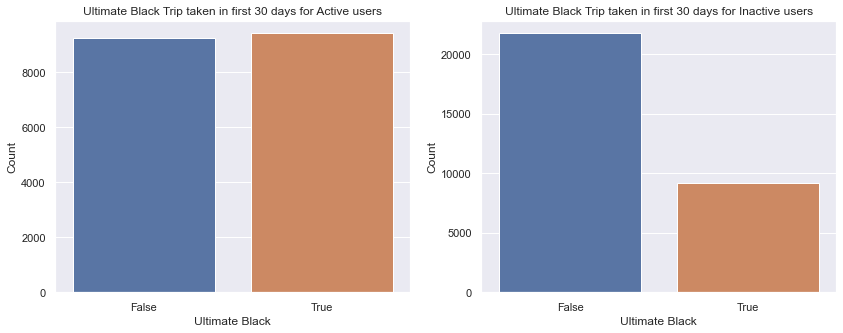

In [69]:
# plot bargraphs of count of cities by active and inactive users
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

sns.barplot(ax=ax1, x=black_act.index, y=black_act)
ax1.set_xlabel('Ultimate Black')
ax1.set_ylabel('Count')
ax1.set_title('Ultimate Black Trip taken in first 30 days for Active users')

sns.barplot(ax=ax2, x=black_inact.index, y=black_inact)
ax2.set_xlabel('Ultimate Black')
ax2.set_ylabel('Count')
ax2.set_title('Ultimate Black Trip taken in first 30 days for Inactive users')

plt.show()

For active users, there's roughly an equal number of users who have taken an ultimate black trip in their first 30 days.  

For inactive users, there's significantly more users who have NOT taken an ultimate black trip in their first 30 days.

<b>Question:</b> How does the percentage of weekday trips compare for inactive users vs active users?

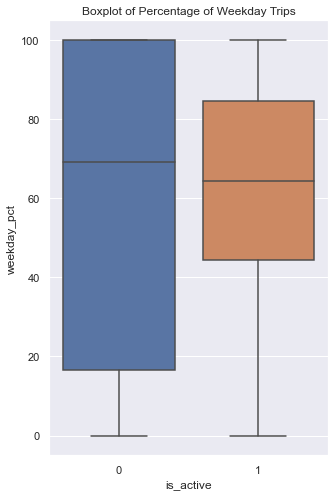

In [70]:
plt.figure(figsize=(5,8))
sns.boxplot(x='is_active', y='weekday_pct', data = df)
plt.title('Boxplot of Percentage of Weekday Trips')
plt.show()

In [71]:
pd.pivot_table(df, index='is_active', aggfunc={'weekday_pct':['mean','median','std']})

weekday_pct                  
                 mean median        std
is_active                              
0           60.611929   69.2  40.979907
1           61.342137   64.3  29.512309

Among inactive users, the percentage of trips that are during weekdays has a much broader range in comparison to active users.  

### Preprocessing

We have a few categorical features that we'll convert to numeric by creating dummy variables. We'll also finalize our features and 

In [72]:
#create dummy variables for categorical features
df_features = pd.get_dummies(df,columns=['city','phone','ultimate_black_user'])
df_features.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,is_active,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,0,1,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,1,0,0,1,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,1,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,0,1,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,0,1,1,0,1,0


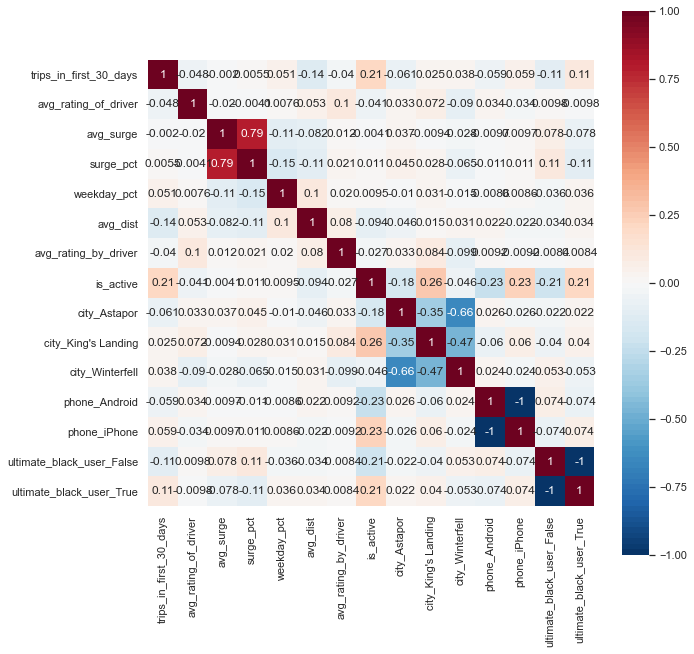

In [73]:
#check correlation
corr = df_features.corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, square = True, cmap=sns.color_palette("RdBu_r", 100))
plt.show()

In [74]:
df_features.columns

Index(['trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'surge_pct', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'is_active', 'city_Astapor',
       'city_King's Landing', 'city_Winterfell', 'phone_Android',
       'phone_iPhone', 'ultimate_black_user_False',
       'ultimate_black_user_True'],
      dtype='object')

In [75]:
#set target variable
target = df_features['is_active']

# drop date features, one of the binary dummy features, and target variable
df_features = df_features.drop(['last_trip_date',
                                'signup_date',
                                'is_active',
                                'phone_Android',
                                'ultimate_black_user_False'
                               ],axis=1)

In [76]:
#save column labels for feature impact analysis later
cols = df_features.columns

In [77]:
# split into train, test sets
#ensure that target variable is distributed evenly by setting stratify parameter

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_features, 
                                                    target, 
                                                    test_size=0.2,
                                                    random_state=16,
                                                    stratify=target
                                                   )

We'll check if the stratification was done correctly.

In [78]:
# original percentage of target = 1
sum(target == 1) / len(target)

0.37644923883455994

In [79]:
# train percentage of target = 1
sum(y_train == 1) / len(y_train)

0.37644923883455994

In [80]:
# test percentage of target = 1
sum(y_test == 1) / len(y_test)

0.37644923883455994

Since our input variables are on different scales, we'll apply the standard scaler to them

In [81]:
from sklearn.preprocessing import StandardScaler

# instantiate standard scaler
sc = StandardScaler()

# fit standard scaler on train set and transform
X_train_sc = sc.fit_transform(X_train)

# transform test set
X_test_sc = sc.transform(X_test)

### Modeling

We'll train, test, and compare three models:
- Logistic Regression
- Random Forest
- XGBoost

As for metrics, we'll use accuracy to determine the best model.  We will still generate precision and recall scores, but since we are not concerned with accurately predicting one specific class, accuracy will suffice.  Furthermore, since our model is not heavily imbalanced, accuracy will be a good metric.  

We will also look at the ROC curves for each of these models.

In [82]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, auc

In [83]:
# calculate the fpr and tpr for all thresholds of the classification
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

#### Logistic Regression

In [84]:
# Specify parameters and distributions to sample from
param_dist_lr = {'solver':['newton-cg', 'lbfgs', 'liblinear'],
              'penalty':['l2'],
              'C':[100, 10, 1.0, 0.1, 0.01]
             }

In [85]:
# build logisic regression classifier
lr = LogisticRegression()

random_lr = RandomizedSearchCV(lr,
                               param_distributions=param_dist_lr,
                               n_iter=15,
                               scoring='accuracy',
                               cv=3,
                               random_state=16
                              )

random_lr.fit(X_train_sc, y_train)

RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=15,
                   param_distributions={'C': [100, 10, 1.0, 0.1, 0.01],
                                        'penalty': ['l2'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear']},
                   random_state=16, scoring='accuracy')

In [86]:
print('Best hyperparameters:', random_lr.best_params_)
acc_lr = random_lr.best_score_
print('Best accuracy score:', acc_lr)

Best hyperparameters: {'solver': 'newton-cg', 'penalty': 'l2', 'C': 0.01}
Best accuracy score: 0.7190996977464431


In [87]:
best_lr = random_lr.best_estimator_

y_train_pred_lr = best_lr.predict(X_train_sc)
y_test_pred_lr = best_lr.predict(X_test_sc)

In [88]:
print("[Training Classification Report]")
print(classification_report(y_train, y_train_pred_lr))

print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_lr))

[Training Classification Report]
              precision    recall  f1-score   support

           0       0.74      0.86      0.79     24740
           1       0.67      0.49      0.57     14936

    accuracy                           0.72     39676
   macro avg       0.70      0.67      0.68     39676
weighted avg       0.71      0.72      0.71     39676

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.74      0.86      0.79      6185
           1       0.68      0.49      0.57      3734

    accuracy                           0.72      9919
   macro avg       0.71      0.68      0.68      9919
weighted avg       0.72      0.72      0.71      9919



In [89]:
#create confusion matrices

cm_lr_train = confusion_matrix(y_train, y_train_pred_lr)
cm_lr_test = confusion_matrix(y_test, y_test_pred_lr)

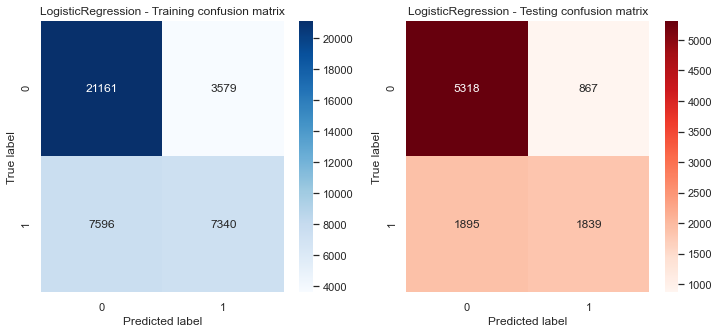

In [90]:
# plot confusion matrices
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(cm_lr_train, annot=True, fmt = '', cmap = 'Blues', ax = ax[0])
ax[0].set_xlabel('Predicted label')
ax[0].set_ylabel('True label')
ax[0].set_title('LogisticRegression - Training confusion matrix')

sns.heatmap(cm_lr_test, annot=True, fmt = '', cmap = 'Reds', ax = ax[1])
ax[1].set_xlabel('Predicted label')
ax[1].set_ylabel('True label')
ax[1].set_title('LogisticRegression - Testing confusion matrix')

plt.show()

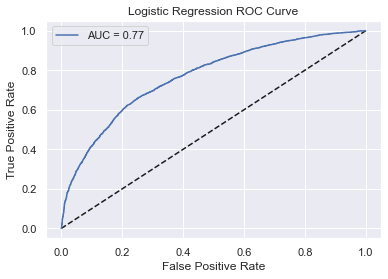

In [91]:
y_pred_prob_lr = best_lr.predict_proba(X_test_sc)[:, 1]

fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_pred_prob_lr)
auc_lr = auc(fpr_lr, tpr_lr)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label = 'AUC = %0.2f' % auc_lr)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

#### Random Forest

In [92]:
# Specify parameters to sample from
param_dist_rf = {'n_estimators':[100, 200, 300],
                 "max_depth": [10, 20, 40, 100, None],
                 "bootstrap": [True, False],
                 "criterion": ["gini", "entropy"]}

In [93]:
# build random forest classifier
rf = RandomForestClassifier(random_state=16)

random_rf = RandomizedSearchCV(rf,
                               param_distributions=param_dist_rf,
                               n_iter=20,
                               scoring='accuracy',
                               cv=3,
                               random_state=16,
                               verbose=1
                              )

random_rf.fit(X_train_sc, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  4.9min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=16),
                   n_iter=20,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 40, 100, None],
                                        'n_estimators': [100, 200, 300]},
                   random_state=16, scoring='accuracy', verbose=1)

In [94]:
print('Best hyperparameters:', random_rf.best_params_)
acc_rf = random_rf.best_score_
print('Best accuracy score:', acc_rf)

Best hyperparameters: {'n_estimators': 300, 'max_depth': 10, 'criterion': 'gini', 'bootstrap': True}
Best accuracy score: 0.7839247397123402


In [95]:
best_rf = random_rf.best_estimator_

y_test_pred_rf = best_rf.predict(X_test_sc)

In [96]:
print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_rf))

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      6185
           1       0.75      0.66      0.70      3734

    accuracy                           0.79      9919
   macro avg       0.78      0.76      0.77      9919
weighted avg       0.78      0.79      0.78      9919



In [97]:
#create confusion matrices

cm_rf_test = confusion_matrix(y_test, y_test_pred_rf)

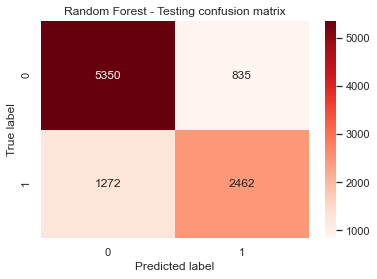

In [98]:
sns.heatmap(cm_rf_test, annot=True, fmt = '', cmap = 'Reds')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Random Forest - Testing confusion matrix')

plt.show()

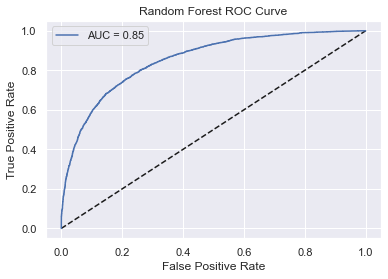

In [99]:
y_pred_prob_rf = best_rf.predict_proba(X_test_sc)[:, 1]

fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_prob_rf)
auc_rf = auc(fpr_rf, tpr_rf)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label = 'AUC = %0.2f' % auc_rf)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

#### XGBoost

In [100]:
# Specify parameters to sample from
params_xg = {'max_depth': [3, 5, 6, 10, 15],
             'learning_rate': [0.01, 0.1, 0.2, 0.3],
             'subsample': np.arange(0.5, 1.0, 0.1),
             'colsample_bytree': np.arange(0.4, 1.0, 0.1),
             'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
             'n_estimators': [100, 200, 300, 400, 500]}

In [101]:
# build XGBoost classifier
xg = xgb.XGBClassifier(eval_metric = 'logloss', random_state=16, use_label_encoder=False)

random_xg = RandomizedSearchCV(xg,
                               param_distributions=params_xg,
                               n_iter=20,
                               scoring='accuracy',
                               cv=3,
                               random_state=16,
                               verbose=1
                              )

random_xg.fit(X_train_sc, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.1min finished


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=na...
                                           validate_parameters=None,
                                           verbosity=None),
                   n_iter=20,
                   par

In [102]:
print('Best hyperparameters:', random_xg.best_params_)
acc_xg = random_xg.best_score_
print('Best accuracy score:', acc_xg)

Best hyperparameters: {'subsample': 0.8999999999999999, 'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.7999999999999999, 'colsample_bylevel': 0.4}
Best accuracy score: 0.7895705304830539


In [103]:
best_xg = random_xg.best_estimator_

y_test_pred_xg = best_xg.predict(X_test_sc)

In [104]:
print("[Test Classification Report]")
print(classification_report(y_test, y_test_pred_xg))

[Test Classification Report]
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      6185
           1       0.75      0.67      0.70      3734

    accuracy                           0.79      9919
   macro avg       0.78      0.77      0.77      9919
weighted avg       0.79      0.79      0.79      9919



In [105]:
#create confusion matrices

cm_xg_test = confusion_matrix(y_test, y_test_pred_xg)

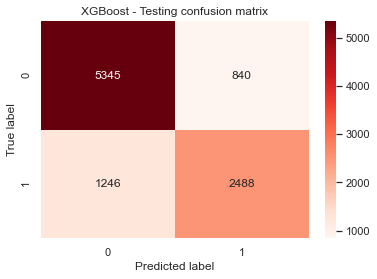

In [106]:
sns.heatmap(cm_xg_test, annot=True, fmt = '', cmap = 'Reds')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('XGBoost - Testing confusion matrix')

plt.show()

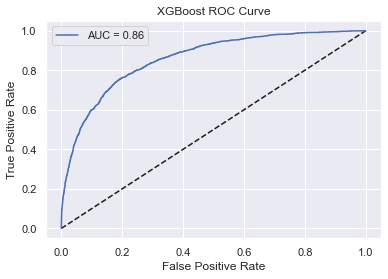

In [107]:
y_pred_prob_xg = best_xg.predict_proba(X_test_sc)[:, 1]

fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_test, y_pred_prob_xg)
auc_xg = auc(fpr_xg, tpr_xg)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_xg, tpr_xg, label = 'AUC = %0.2f' % auc_xg)
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.show()

#### Model comparison

In [108]:
# create our metrics table
models = pd.DataFrame({'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
                       'Accuracy':[acc_lr, acc_rf, acc_xg],
                       'AUROC':[auc_lr, auc_rf, auc_xg]
                      })
models.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,AUROC
2,XGBoost,0.789571,0.858739
1,Random Forest,0.783925,0.853825
0,Logistic Regression,0.719100,0.768248


Our XGBoost model performs the best with the highest accuracy score and the highest area under the ROC curve. 

### Feature impact

We'll use the SHAP package to understand how high/low values of our features impact the target variable.  The graphs show the SHAP value, which is an indicator of positive/negative impact on the target value.

In [109]:
from shap import TreeExplainer
from shap import summary_plot

In [110]:
explainer = TreeExplainer(best_xg)
shap_values = explainer.shap_values(X_train_sc)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


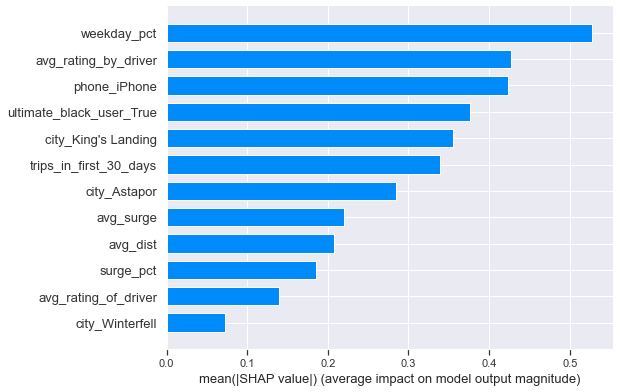

In [111]:
summary_plot(shap_values, X_train_sc, plot_type="bar", feature_names = cols)

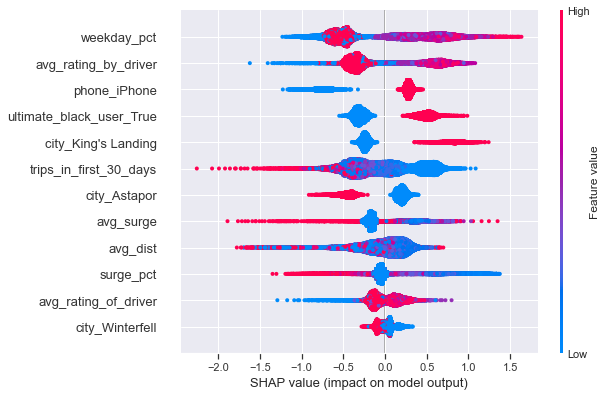

In [112]:
summary_plot(shap_values, X_train_sc, feature_names = cols, show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)

Based on our SHAP analysis, the features that had the greatest impact on our target variable were:
- weekday_pct
- avg_rating_by_driver
- phone_iPhone
- ultimate_black_user_True
- city_King's Landing
- trips_in_first_30_days

The following features <u>increase</u> the likelihood that a user will be retained:
- User's phone is an iPhone
- User took an Ultimate Black in their first 30 days
- User is from King's Landing
- User has <i>fewer</i> trips in their first 30 days
- User is <i>not</i> from Astaphor

The following features <u>decrease</u> the likelihood that a user will be retained:
- User's phone is an Android
- User has not taken an Ultimate Black in their first 30 days
- User is <i>not</i> from King's Landing
- User takes more trips during first 30 days
- User is from Astaphor

Based on these insights, here are the <b>recommendations</b> for Ultimate to increase retention among their users:
1. Target iPhone users for new customers
2. Offer incentives to riders to try Ultimate Black in their first 30 days
3. Target new customers that live in King's Landing.